In [1]:
import findspark
findspark.init()

In [243]:
# from pyspark import SparkContext
from pyspark.sql.functions import explode,concat,monotonically_increasing_id, row_number,coalesce
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.functions import monotonically_increasing_id 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
spark = SparkSession.builder.master("local").appName("Search").config(conf=SparkConf()).getOrCreate()

In [190]:
from pyspark.sql.types import StructType, StructField, StringType,BooleanType,IntegerType

In [199]:
df = spark.read.format("csv").option("header", "true").load("../2015_data/2015_data.csv")
df.select('icd_code_10th_revision').show(n=5)


+----------------------+
|icd_code_10th_revision|
+----------------------+
|                  I500|
|                  C349|
|                  G309|
|                   X91|
|                  I250|
+----------------------+
only showing top 5 rows



In [66]:
# codes = spark.read.option("multiline","true").json("../2015_data/2015.json")
# codes.select('icd_code_10th_revision').show()


### Race and gun deathes

In [67]:
# some convenience reference data regarding the CDC ICD codes
icd_gun_deaths = ['X72','X73','X74','X93','X94','X95','W32','W33','W34','Y22','Y23','Y24','Y35.0','Y36.4','U01.4']
icd_gun_homicides = ['X93','X94','X95']
icd_gun_suicides = ['X72','X73','X74']
icd_gun_accident = ['W32','W33','W34']
icd_gun_other = ['Y22','Y23','Y24','Y35.0','Y36.4','U01.4']

In [68]:
df_guns = df.filter(df.icd_code_10th_revision.isin(icd_gun_deaths))

In [69]:
def race_reclassify(race, hisp_orig):
    if hisp_orig == '6':
        return 'White'
    elif hisp_orig == '7':
        return 'Black'
    elif hisp_orig == '8':
        if race == '03':
            return "Native American"
        else:
            return "Asian/Pacific Islander"
    else:
        return 'Hispanic'

In [70]:

df_2 = spark.createDataFrame(
    df.rdd.map(lambda row: row + (race_reclassify(row.race,row.hispanic_originrace_recode), )), 
    df.schema.add(StructField("race_decoded", StringType())))
df_2.select('race_decoded').show()

+---------------+
|   race_decoded|
+---------------+
|          White|
|          White|
|          White|
|Native American|
|          White|
|Native American|
|          White|
|          White|
|          White|
|          White|
|          White|
|          White|
|          White|
|          White|
|          White|
|Native American|
|Native American|
|          White|
|Native American|
|          White|
+---------------+
only showing top 20 rows



In [74]:
df_races_deaths=df_2.groupby('race_decoded').count()
df_races_deaths.show()

+--------------------+-------+
|        race_decoded|  count|
+--------------------+-------+
|     Native American|  18062|
|Asian/Pacific Isl...|  65874|
|               White|2125954|
|            Hispanic| 192533|
|               Black| 315775|
+--------------------+-------+



In [76]:
df_races_guns=df_2.filter(df_2.icd_code_10th_revision.isin(icd_gun_deaths)).groupby('race_decoded').count()
df_races_guns.show()

+--------------------+-----+
|        race_decoded|count|
+--------------------+-----+
|     Native American|  345|
|Asian/Pacific Isl...|  494|
|               White|22794|
|               Black| 8807|
|            Hispanic| 3411|
+--------------------+-----+



In [77]:
df_races_deaths_pd = df_races_deaths.toPandas()
df_races_guns_pd = df_races_guns.toPandas()

In [163]:
row = df_races_deaths_pd.iloc[3,:]
df_races_deaths_pd.iloc[3,:] = df_races_deaths_pd.iloc[4,:]
df_races_deaths_pd.iloc[4,:] = row
df_races_deaths_pd

,race_decoded,count
0,Native American,18062
1,Asian/Pacific Islander,65874
2,White,2125954
3,Black,315775
4,Hispanic,192533


In [165]:
df_races_guns_pd['all']=df_races_deaths_pd['count']
df_races_guns_pd['death by gun percentage'] = 100*df_races_guns_pd['count']/df_races_guns_pd['all']
df_races_guns_pd

,race_decoded,count,others,all,gun percentage,death by gun percentage
0,Native American,345,17717,18062,1.910087,1.910087
1,Asian/Pacific Islander,494,65380,65874,0.749917,0.749917
2,White,22794,2103160,2125954,1.072177,1.072177
3,Black,8807,183726,315775,4.574281,2.789011
4,Hispanic,3411,312364,192533,1.080200,1.771644


In [421]:
df_draw = df_races_guns_pd[['race_decoded','death by gun percentage']]
df_draw=df_draw.rename(columns={'race_decoded':'race'})
df_draw = df_draw.sort_values(by='death by gun percentage',ascending=False)
df_draw.set_index('race',inplace=True)
df_draw

,death by gun percentage
race,
Black,2.789011
Native American,1.910087
Hispanic,1.771644
White,1.072177
Asian/Pacific Islander,0.749917


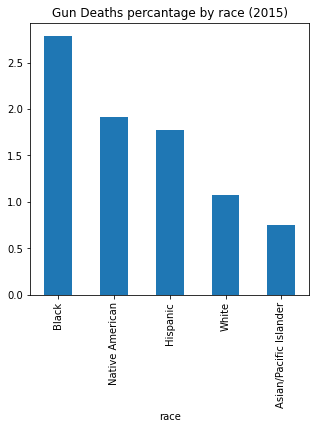

In [422]:
df_draw.plot.bar( figsize=(5,5), title='Gun Deaths percantage by race (2015)',legend=False);

> Black are the dying with guns more than other races and then comes native americans and hispanics.

### vehicle and gun deaths

In [123]:
vehicle_358_cause_recode = list(range(385,398))
vehicle_358_cause_recode=[str(ele) for ele in vehicle_358_cause_recode]
vehicle_113_cause_recode=['114']
vehicle_130_infant_cause_recode=['141']
vehicle_39_cause_recode = ["038"]

In [124]:
df_vehicle=df.filter(df['358_cause_recode'].isin(vehicle_358_cause_recode) | 
                     df['358_cause_recode'].isin(vehicle_113_cause_recode) |
                    df['130_infant_cause_recode'].isin(vehicle_130_infant_cause_recode)|
                    df['39_cause_recode'].isin(vehicle_39_cause_recode)).count()



In [132]:
sum(df_races_deaths_pd['count'])/df_vehicle

70.66127690547988

In [417]:
df_draw = pd.DataFrame({'deaths percentage':[0,0]})
df_draw.index = ['guns','vehicles']

In [418]:
df_draw.loc['vehicles','deaths percentage']=100*df_vehicle/sum(df_races_deaths_pd['count'])
df_draw.loc['guns','deaths percentage']=100*sum(df_races_guns_pd['count'])/sum(df_races_deaths_pd['count'])

In [419]:
df_draw = df_draw.sort_values(by='deaths percentage',ascending=False)
df_draw

,deaths percentage
vehicles,1.415202
guns,1.318925


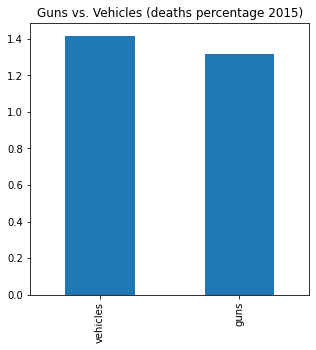

In [420]:
df_draw.plot.bar( figsize=(5,5), title='Guns vs. Vehicles (deaths percentage 2015)',legend=False);

> There is almost no difference between the rates of death by guns and vehicles (around 1.4% each)

### suicide correlation of age and education

In [200]:
df_suicide =spark.createDataFrame(
    df.rdd.map(lambda row: row + (int(row.manner_of_death=='2'), )), 
    df.schema.add(StructField("is_suicide", IntegerType())))

In [201]:
df_age_suicide = df_suicide.groupby('age_recode_12').agg(f.mean('is_suicide'))

In [202]:
df_age_suicide.show()

+-------------+--------------------+
|age_recode_12|     avg(is_suicide)|
+-------------+--------------------+
|           07| 0.05022778913234606|
|           11|0.001428828860250...|
|           01|                 0.0|
|           09| 0.00852299637032006|
|           05| 0.13478395180908986|
|           08| 0.02166948944799768|
|           03| 0.07590759075907591|
|           02|                 0.0|
|           06| 0.09482969860328351|
|           10|0.003923712380134894|
|           12| 0.02680965147453083|
|           04| 0.17940697295536004|
+-------------+--------------------+



In [204]:
ages_map_dict = {
"10":"75 - 84 years",
"11":"85 years and over",
"12":"Age not stated",
"01":"Under 1 year (includes not stated infant ages)",
"02":"1 - 4 years",
"03":"5 - 14 years",
"04":"15 - 24 years",
"05":"25 - 34 years",
"06":"35 - 44 years",
"07":"45 - 54 years",
"08":"55 - 64 years",
"09":"65 - 74 years",
}

In [222]:
df_age_suicide_pd = df_age_suicide.toPandas()
df_age_suicide_pd

,age_recode_12,avg(is_suicide)
0,07,0.050228
1,11,0.001429
2,01,0.000000
3,09,0.008523
4,05,0.134784
5,08,0.021669
6,03,0.075908
7,02,0.000000
8,06,0.094830
9,10,0.003924


In [223]:
df_age_suicide_pd['age_recode_12_2'] = df_age_suicide_pd['age_recode_12'].astype('int')
df_age_suicide_pd = df_age_suicide_pd.sort_values(by='age_recode_12_2')

In [413]:
df_draw = df_age_suicide_pd.rename(columns={'avg(is_suicide)':'suicide_percentage','age_recode_12':'age'})
df_draw['age'] = df_draw['age'].map(ages_map_dict)
df_draw

,age,suicide_percentage,age_recode_12_2
2,Under 1 year (includes not stated infant ages),0.000000,1
7,1 - 4 years,0.000000,2
6,5 - 14 years,0.075908,3
11,15 - 24 years,0.179407,4
4,25 - 34 years,0.134784,5
8,35 - 44 years,0.094830,6
0,45 - 54 years,0.050228,7
5,55 - 64 years,0.021669,8
3,65 - 74 years,0.008523,9
9,75 - 84 years,0.003924,10


In [414]:
df_draw['suicide_percentage'] = 100* df_draw['suicide_percentage']
df_draw

,age,suicide_percentage,age_recode_12_2
2,Under 1 year (includes not stated infant ages),0.000000,1
7,1 - 4 years,0.000000,2
6,5 - 14 years,7.590759,3
11,15 - 24 years,17.940697,4
4,25 - 34 years,13.478395,5
8,35 - 44 years,9.482970,6
0,45 - 54 years,5.022779,7
5,55 - 64 years,2.166949,8
3,65 - 74 years,0.852300,9
9,75 - 84 years,0.392371,10


In [415]:
df_draw = df_draw.set_index('age')

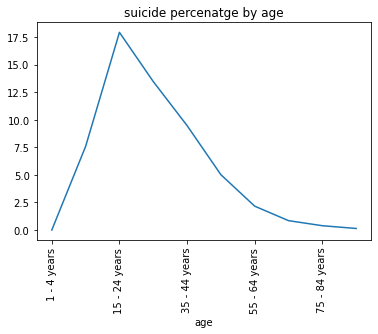

In [416]:
df_draw[['suicide_percentage']].iloc[1:-1,:].plot(title='suicide percenatge by age',legend=False)
plt.xticks(rotation=90);

> The graph shows a peak in the 15-24 years youth for about 17.5% and then gets low again.
 

In [330]:

education_2003_revision={
"00":"No formal education",
"1":"8th grade or less",
"2":"9 - 12th grade, no diploma",
"3":"high school graduate or GED completed",
"4":"some college credit, but no degree",
"5":"Associate degree",
"6":"Bachelor’s degree",
"7":"Master’s degree",
"8":"Doctorate or professional degree"

}

In [271]:
df_education_suicide = df_suicide.select(df_suicide['is_suicide'],coalesce(df_suicide["education_1989_revision"], df_suicide["education_2003_revision"]).alias('all_education'))

In [272]:
df_education_suicide = df_education_suicide.groupby('all_education').agg(f.sum('is_suicide'),f.count('is_suicide'))
df_education_suicide_pd = df_education_suicide.toPandas()

In [408]:
df_draw = df_education_suicide_pd.copy()
df_draw = df_draw.set_index('all_education')


In [409]:
for i in range(1,9):
    
    df_draw.loc['1',['sum(is_suicide)','count(is_suicide)']] += df_draw.loc['0'+str(i),['sum(is_suicide)','count(is_suicide)']]
#     print(df_draw.loc['8',['sum(is_suicide)','count(is_suicide)']])
df_draw.loc['2',['sum(is_suicide)','count(is_suicide)']] += df_draw.loc['09',['sum(is_suicide)','count(is_suicide)']]

for i in range(10,13):
    df_draw.loc['2',['sum(is_suicide)','count(is_suicide)']] += df_draw.loc[str(i),['sum(is_suicide)','count(is_suicide)']]
for i in range(13,18):
    df_draw.loc['4',['sum(is_suicide)','count(is_suicide)']] += df_draw.loc[str(i),['sum(is_suicide)','count(is_suicide)']]

In [410]:
rows_to_drop = ['0'+str(i)for i in range(1,10)]+[str(i)for i in range(10,18)]+['99','9']
df_draw = df_draw.drop(rows_to_drop)
df_draw

,sum(is_suicide),count(is_suicide)
all_education,,
7,1754,103978
3,16853,1077604
8,864,43688
5,3259,154326
00,0,1006
6,5256,261106
1,1665,299608
4,7807,334753
2,5743,321511


In [411]:
df_draw = df_draw.reset_index()
df_draw['sorting'] = df_draw['all_education'].astype('int')
df_draw = df_draw.sort_values(by='sorting')
df_draw['all_education'] = df_draw['all_education'].map(education_2003_revision)
df_draw

,all_education,sum(is_suicide),count(is_suicide),sorting
4,No formal education,0,1006,0
6,8th grade or less,1665,299608,1
8,"9 - 12th grade, no diploma",5743,321511,2
1,high school graduate or GED completed,16853,1077604,3
7,"some college credit, but no degree",7807,334753,4
3,Associate degree,3259,154326,5
5,Bachelor’s degree,5256,261106,6
0,Master’s degree,1754,103978,7
2,Doctorate or professional degree,864,43688,8


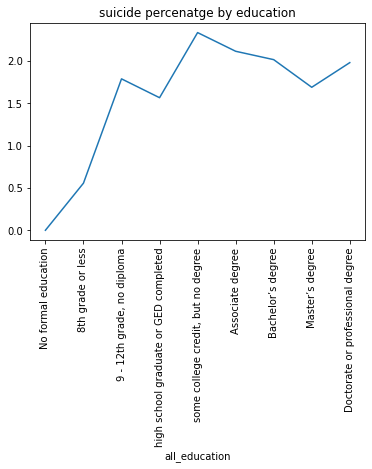

In [412]:
df_draw = df_draw.set_index('all_education')
df_draw['suicide percentage'] = 100*df_draw['sum(is_suicide)']/df_draw['count(is_suicide)']
df_draw[['suicide percentage']].plot(title='suicide percenatge by education',legend=False)
plt.xticks(rotation=90);

> It can be observed that the highest suiscide percentage is among college students with no degree

>This high rate may be related to the age range for college students (20-24).

> The rates remain high with higher degrees although they are olderin lower suicide rates.

### Homicide vs other death causes

In [387]:
df_homicide = df_suicide.groupby('manner_of_death').agg(f.count('manner_of_death'))
df_homicide_pd = df_homicide.toPandas()

In [390]:
df_homicide_pd

,manner_of_death,count(manner_of_death)
0,7,2107352
1,3,18885
2,None,0
3,5,11054
4,1,143961
5,4,4165
6,2,44417


In [391]:
manner_of_death={
"1":"Accident",
"2":"Suicide",
"3":"Homicide",
"4":"Pending investigation",
"5":"Could not determine",
"6":"Self-Inflicted",
"7":"Natural",
"Blank":"Not specified",
}

In [395]:
df_draw

,manner_of_death,death cause
0,Natural,2107352
1,Homicide,18885
3,Could not determine,11054
4,Accident,143961
5,Pending investigation,4165
6,Suicide,44417


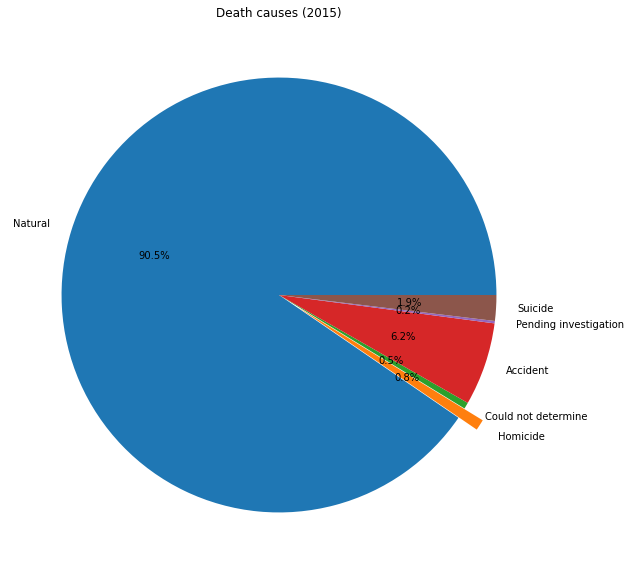

In [406]:
df_draw = df_homicide_pd.copy()
df_draw['manner_of_death'] = df_draw['manner_of_death'].map(manner_of_death)
df_draw = df_draw.rename(columns={'count(manner_of_death)':'death cause'})
df_draw = df_draw.dropna()
explode=(0,0.1,0,0,0,0)
plt.figure(figsize=(10,10))
plt.pie(df_draw['death cause'], autopct='%1.1f%%',labels=df_draw['manner_of_death'],explode=explode);
plt.title('Death causes (2015)');

> Natural causes of death make 90.5% of the total death cases followed by accidents for another 6.5% and the remaining 3% is for other death causes 

Text(0.5, 1.0, 'Death causes (2015)')

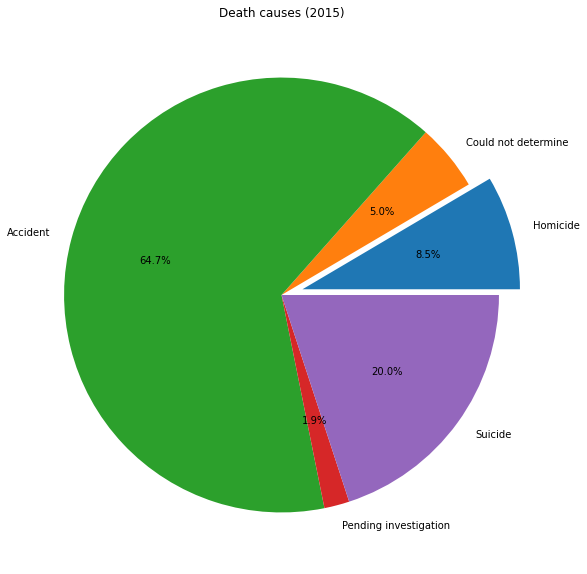

In [407]:
explode=(0.1,0,0,0,0)
plt.figure(figsize=(10,10))

df_draw = df_draw.drop(df_draw[df_draw['manner_of_death']=="Natural"].index)
plt.pie(df_draw['death cause'], autopct='%1.1f%%',labels=df_draw['manner_of_death'],explode=explode);
plt.title('Death causes (2015)')

> Excluding natural reasons for death homicide is 8.5% of the overall death cases, as accidents are the most common death cause with 64.7% percentage.